EXPORTING DATASET TO AWS DYNAMODB

In [2]:
import pandas as pd
import boto3

In [ ]:
# DynamoDB original table

# Dataset definition
original_dataset = pd.read_csv('../data/hotel_original.csv')

# VAR AWS Region
region_name = 'us-east-1'

# VAR AWS DynamoDB Original Table
dynamodb_table_name = 'hotel_reservation_dataset_original'  

# Send to DynamoDB
dynamodb = boto3.resource('dynamodb', region_name)

items = []
for index, row in original_dataset.iterrows():
    item = {
        'Booking_ID': {'S': (row['Booking_ID'])},
        'no_of_adults': {'N': str(row['no_of_adults'])},
        'no_of_children': {'N': str(row['no_of_children'])},
        'no_of_weekend_nights': {'N': str(row['no_of_weekend_nights'])},
        'no_of_week_nights': {'N': str(row['no_of_week_nights'])},
        'type_of_meal_plan': {'S': row['type_of_meal_plan']},
        'required_car_parking_space': {'N': str(row['required_car_parking_space'])},
        'room_type_reserved': {'S': row['room_type_reserved']},
        'lead_time': {'N': str(row['lead_time'])},
        'arrival_year': {'N': str(row['arrival_year'])},
        'arrival_month': {'N': str(row['arrival_month'])},
        'arrival_date': {'N': str(row['arrival_date'])},
        'market_segment_type': {'S': row['market_segment_type']},
        'repeated_guest': {'N': str(row['repeated_guest'])},
        'no_of_previous_cancellations': {'N': str(row['no_of_previous_cancellations'])},
        'no_of_previous_bookings_not_canceled': {'N': str(row['no_of_previous_bookings_not_canceled'])},
        'avg_price_per_room': {'N': str(row['avg_price_per_room'])},
        'no_of_special_requests': {'N': str(row['no_of_special_requests'])},
        'booking_status': {'S': row['booking_status']}
    }
    items.append(item)

dynamodb = boto3.client('dynamodb', region_name)
for item in items:
    response = dynamodb.put_item(
        TableName=dynamodb_table_name,
        Item=item
    )

IMPORTING DATASET FROM DYNAMODB

In [3]:
# VAR AWS Region
region_name = 'us-east-1'

# VAR AWS DynamoDB Table Original Dataset
dynamodb_table_name = 'hotel_reservation_dataset_original'

# Table
dynamodb = boto3.resource('dynamodb', region_name)
table = dynamodb.Table(dynamodb_table_name)

all_items = []
start_key = None

while True:
    #  Pagination
    if start_key:
        response = table.scan(ExclusiveStartKey=start_key)
    else:
        response = table.scan()

    # Add imported items to list
    items_import = response['Items']
    all_items.extend(items_import)

    #  Check if pagination over
    if 'LastEvaluatedKey' in response:
        start_key = response['LastEvaluatedKey']
    else:
        break

In [4]:
# Data Frame imported from DynamoDB
df_imported_from_dynamodb = pd.DataFrame(all_items)
df_imported_from_dynamodb.shape

(36275, 19)

CORRRECTING DATA TYPE

In [ ]:
# Only in case import from DynamoDB comes with JSON specifying all types as string

string_to_int = ["no_of_previous_bookings_not_canceled", "no_of_children", "repeated_guest", "no_of_special_requests", "no_of_adults", "arrival_year", "no_of_week_nights", "required_car_parking_space", "arrival_date", "no_of_weekend_nights", "arrival_month", "lead_time", "no_of_previous_cancellations"]

for column in string_to_int:
    df_imported_from_dynamodb[column] = df_imported_from_dynamodb[column].astype(int)
    
df_imported_from_dynamodb["avg_price_per_room"] = df_imported_from_dynamodb["avg_price_per_room"].astype(float)

print(df_imported_from_dynamodb.dtypes)

GET ORIGINAL DYNAMODB DATASET INFOS

In [6]:
# Shows Dataset shape
rows, columns = df_imported_from_dynamodb.shape
print(f"DataFrame: {rows} ROWS | {columns} COLUMNS")

# Shows data examples
df_imported_from_dynamodb.head()

DataFrame: 36275 ROWS | 19 COLUMNS


,no_of_previous_bookings_not_canceled,room_type_reserved,Booking_ID,no_of_children,repeated_guest,no_of_special_requests,no_of_adults,arrival_year,no_of_week_nights,type_of_meal_plan,booking_status,required_car_parking_space,market_segment_type,avg_price_per_room,arrival_date,no_of_weekend_nights,arrival_month,no_of_previous_cancellations,lead_time
0,0,Room_Type 1,INN21685,0,0,0,2,2017,1,Meal Plan 2,Not_Canceled,0,Offline,94.50,11,2,7,0,96
1,0,Room_Type 4,INN29506,0,0,1,2,2018,3,Meal Plan 1,Canceled,0,Online,105.83,24,1,10,0,267
2,0,Room_Type 1,INN21560,0,0,0,2,2018,2,Not Selected,Canceled,0,Online,85.50,1,0,7,0,142
3,0,Room_Type 1,INN24805,0,0,0,2,2018,4,Not Selected,Canceled,0,Online,95.03,2,1,5,0,102
4,0,Room_Type 1,INN30276,0,0,0,2,2018,2,Meal Plan 2,Canceled,0,Offline,101.00,13,1,5,0,309


In [ ]:
# Shows data type
print(df_imported_from_dynamodb.dtypes)

# Check null data
df_imported_from_dynamodb.isnull().sum()

In [ ]:
# Describe data
df_imported_from_dynamodb.describe()

ADD CLASSIFICATION COLUMN TO ORIGINAL DATASET IMPORTED FROM DYNAMODB

In [7]:
# df_imported_from_dynamodb is the original dataset imported from DynamoDB

# Function that categorizes prices
def price_label(room_price):
    if room_price <= 85:
        return 1
    elif 85 < room_price < 115:
        return 2
    else:
        return 3

df_altered_table = df_imported_from_dynamodb

# Create column <label_avg_price_per_room>
df_altered_table['label_avg_price_per_room'] = df_altered_table['avg_price_per_room'].apply(lambda x: price_label(x))

# Delete column <avg_price_per_room>
df_altered_table = df_altered_table.drop(columns="avg_price_per_room")

DATA VISUALIZATION

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='label_avg_price_per_room', ylabel='count'>

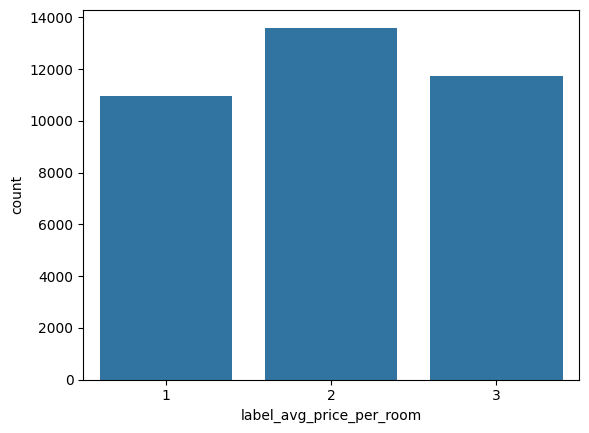

In [9]:
# Count itens in each label
sns.countplot(x = df_altered_table['label_avg_price_per_room'])

DATA PREPROCESSING

In [10]:
# The column to be classified is placed in the first position
df_altered_table.columns
columns = []

columns.append('label_avg_price_per_room')
for i in range(len(df_altered_table.columns[:-1])):
    columns.append(df_altered_table.columns[i])
    
df_altered_table = df_altered_table[columns]
df_altered_table

,label_avg_price_per_room,no_of_previous_bookings_not_canceled,room_type_reserved,Booking_ID,no_of_children,repeated_guest,no_of_special_requests,no_of_adults,arrival_year,no_of_week_nights,type_of_meal_plan,booking_status,required_car_parking_space,market_segment_type,arrival_date,no_of_weekend_nights,arrival_month,no_of_previous_cancellations,lead_time
0,2,0,Room_Type 1,INN21685,0,0,0,2,2017,1,Meal Plan 2,Not_Canceled,0,Offline,11,2,7,0,96
1,2,0,Room_Type 4,INN29506,0,0,1,2,2018,3,Meal Plan 1,Canceled,0,Online,24,1,10,0,267
2,2,0,Room_Type 1,INN21560,0,0,0,2,2018,2,Not Selected,Canceled,0,Online,1,0,7,0,142
3,2,0,Room_Type 1,INN24805,0,0,0,2,2018,4,Not Selected,Canceled,0,Online,2,1,5,0,102
4,2,0,Room_Type 1,INN30276,0,0,0,2,2018,2,Meal Plan 2,Canceled,0,Offline,13,1,5,0,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,1,0,Room_Type 1,INN21370,0,0,0,2,2018,1,Not Selected,Canceled,0,Online,18,0,3,0,28
36271,1,0,Room_Type 1,INN02510,0,0,0,2,2018,4,Not Selected,Not_Canceled,0,Offline,16,2,11,0,121
36272,3,0,Room_Type 1,INN18956,0,0,1,2,2018,0,Meal Plan 2,Canceled,0,Offline,23,2,10,0,386
36273,2,0,Room_Type 1,INN03265,0,0,0,1,2018,2,Meal Plan 1,Not_Canceled,0,Offline,24,0,6,0,192


In [10]:
# Observing the classifications of the classifier columns
classifier_columns = ['room_type_reserved', 'type_of_meal_plan', 'booking_status', 'market_segment_type']

results = []
for column in classifier_columns:
    unique_values = np.unique(df_altered_table[column])
    print(f"Unique values for '{column}': {' | '.join(unique_values)}")
    print()


Unique values for 'room_type_reserved': Room_Type 1 | Room_Type 2 | Room_Type 3 | Room_Type 4 | Room_Type 5 | Room_Type 6 | Room_Type 7

Unique values for 'type_of_meal_plan': Meal Plan 1 | Meal Plan 2 | Meal Plan 3 | Not Selected

Unique values for 'booking_status': Canceled | Not_Canceled

Unique values for 'market_segment_type': Aviation | Complementary | Corporate | Offline | Online



In [14]:
# Dummy variables
df_altered_table_dummies = pd.get_dummies(df_altered_table, prefix = ['room_type_reserved', 'type_of_meal_plan', 'booking_status', 'market_segment_type'],
                   columns = ['room_type_reserved', 'type_of_meal_plan', 'booking_status', 'market_segment_type'])

# Set Booking_ID as table index to contain numbers only
df_altered_table_dummies = df_altered_table_dummies.set_index('Booking_ID')
df_altered_table_dummies

,label_avg_price_per_room,no_of_previous_bookings_not_canceled,no_of_children,repeated_guest,no_of_special_requests,no_of_adults,arrival_year,no_of_week_nights,required_car_parking_space,arrival_date,...,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,booking_status_Canceled,booking_status_Not_Canceled,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
Booking_ID,,,,,,,,,,,,,,,,,,,,,
INN21685,2,0,0,0,0,2,2017,1,0,11,...,True,False,False,False,True,False,False,False,True,False
INN29506,2,0,0,0,1,2,2018,3,0,24,...,False,False,False,True,False,False,False,False,False,True
INN21560,2,0,0,0,0,2,2018,2,0,1,...,False,False,True,True,False,False,False,False,False,True
INN24805,2,0,0,0,0,2,2018,4,0,2,...,False,False,True,True,False,False,False,False,False,True
INN30276,2,0,0,0,0,2,2018,2,0,13,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN21370,1,0,0,0,0,2,2018,1,0,18,...,False,False,True,True,False,False,False,False,False,True
INN02510,1,0,0,0,0,2,2018,4,0,16,...,False,False,True,False,True,False,False,False,True,False
INN18956,3,0,0,0,1,2,2018,0,0,23,...,True,False,False,True,False,False,False,False,True,False


In [15]:
# Calculates the correlation between the dataframe's columns
df_altered_table_dummies.corr()

,label_avg_price_per_room,no_of_previous_bookings_not_canceled,no_of_children,repeated_guest,no_of_special_requests,no_of_adults,arrival_year,no_of_week_nights,required_car_parking_space,arrival_date,...,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,booking_status_Canceled,booking_status_Not_Canceled,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
label_avg_price_per_room,1.000000,-0.101641,0.195747,-0.157091,0.193118,0.260361,0.181640,-0.005931,0.050132,0.006782,...,0.133887,-0.009230,-0.091924,0.166523,-0.166523,-0.003966,-0.133540,-0.176413,-0.232348,0.333119
no_of_previous_bookings_not_canceled,-0.101641,1.000000,-0.021189,0.539156,0.027377,-0.119166,0.026422,-0.049344,0.063810,-0.001498,...,-0.026980,0.001651,-0.030894,-0.060179,0.060179,0.001830,0.138194,0.265171,-0.051977,-0.107395
no_of_children,0.195747,-0.021189,1.000000,-0.036348,0.124486,-0.019787,0.045983,0.024398,0.034244,0.025482,...,-0.025921,-0.003070,-0.079789,0.033078,-0.033078,-0.015375,0.005196,-0.057469,-0.133710,0.154620
repeated_guest,-0.157091,0.539156,-0.036348,1.000000,-0.011820,-0.192277,-0.018175,-0.099764,0.110909,-0.015949,...,-0.045902,0.012953,-0.050816,-0.107287,0.107287,0.038084,0.195898,0.418850,-0.069139,-0.181371
no_of_special_requests,0.193118,0.027377,0.124486,-0.011820,1.000000,0.189401,0.053205,0.045994,0.087922,0.018352,...,-0.092841,-0.000294,0.047713,-0.253070,0.253070,-0.046345,0.034878,-0.122690,-0.339198,0.377446
no_of_adults,0.260361,-0.119166,-0.019787,-0.192277,0.189401,1.000000,0.076719,0.105622,0.011429,0.026338,...,0.017804,0.003509,0.020643,0.086920,-0.086920,-0.093975,-0.072766,-0.287651,-0.082993,0.242919
arrival_year,0.181640,0.026422,0.045983,-0.018175,0.053205,0.076719,1.000000,0.032672,0.015684,0.018849,...,-0.169844,-0.000625,0.118352,0.179529,-0.179529,0.027511,-0.047844,-0.042563,-0.163854,0.182180
no_of_week_nights,-0.005931,-0.049344,0.024398,-0.099764,0.045994,0.105622,0.032672,1.000000,-0.048784,-0.009305,...,-0.041908,-0.005029,-0.072001,0.092996,-0.092996,0.027162,-0.071314,-0.123045,-0.010714,0.080895
required_car_parking_space,0.050132,0.063810,0.034244,0.110909,0.087922,0.011429,0.015684,-0.048784,1.000000,-0.000037,...,-0.031738,0.011452,-0.004545,-0.086185,0.086185,0.005774,0.029095,0.084354,-0.102429,0.049616
arrival_date,0.006782,-0.001498,0.025482,-0.015949,0.018352,0.026338,0.018849,-0.009305,-0.000037,1.000000,...,0.024123,0.002959,-0.001861,0.010629,-0.010629,-0.001594,-0.006916,0.002723,-0.014699,0.014280


<Axes: >

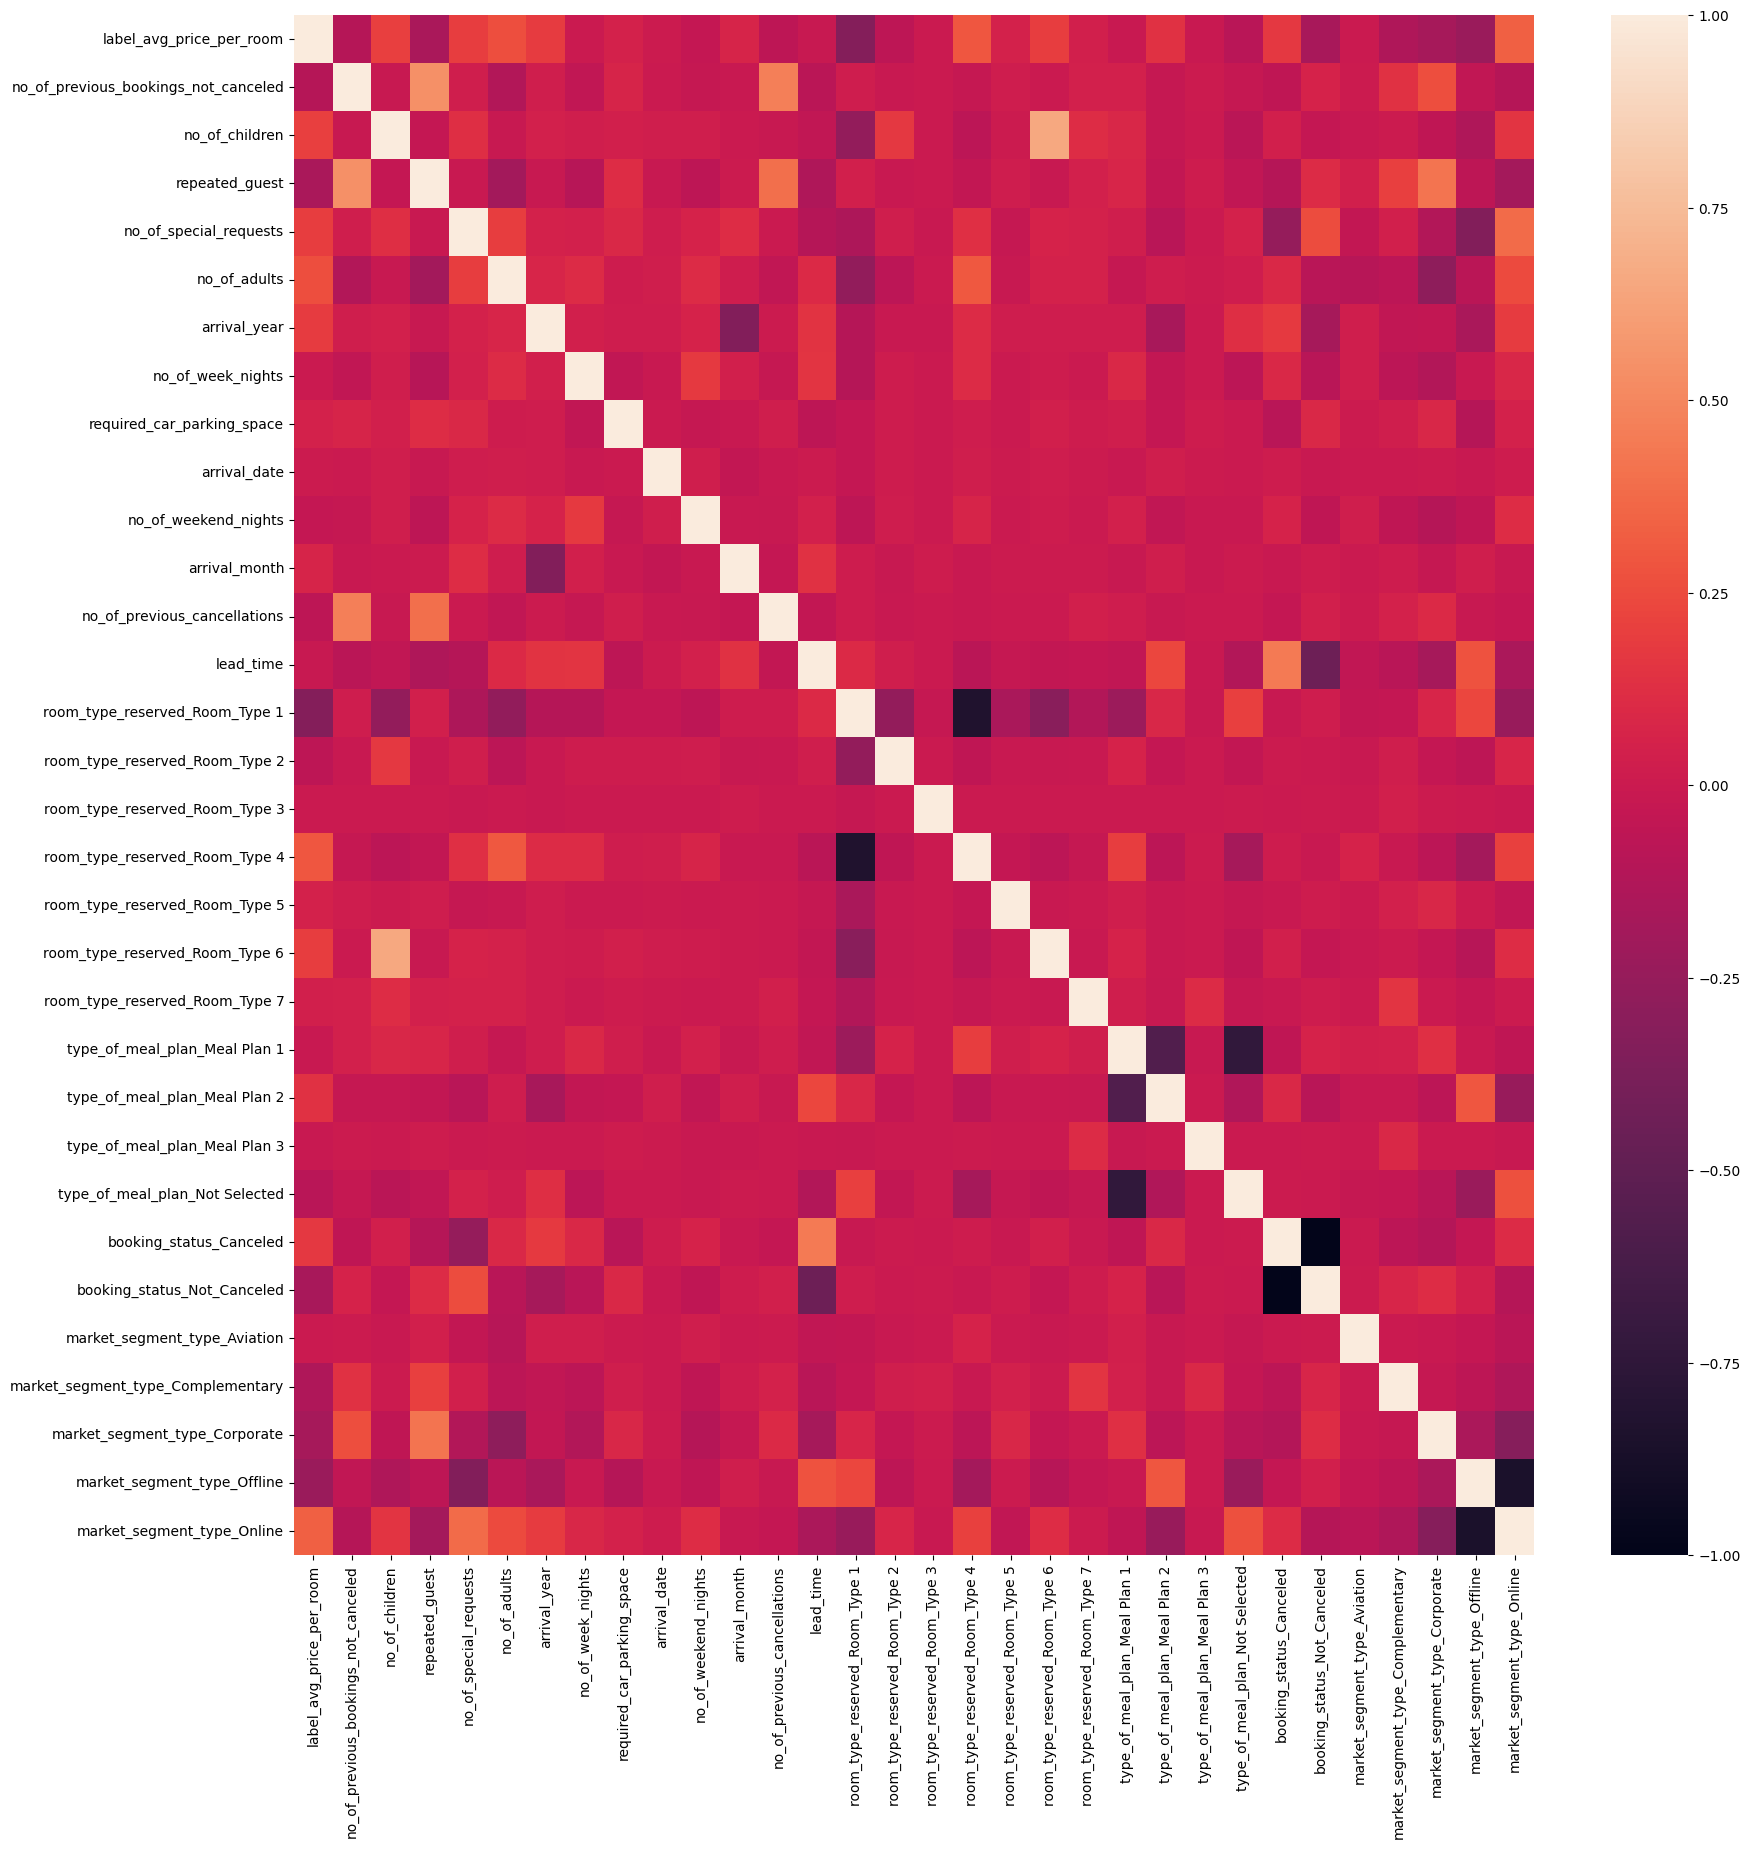

In [20]:
# Heatmap visualization of the correlation matrix
correlation = plt.figure(figsize = (20,20))
sns.heatmap(df_altered_table_dummies.corr())

EXPORTING ALTERED DUMMIE DATASET TO DYNAMODB

In [ ]:
# DynamoDB altered table

# VAR AWS Region
region_name = 'us-east-1'

# VAR AWS DynamoDB Altered Table
dynamodb_altered_table_name = 'hotel_reservation_dataset_altered'  

# TODO: